In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Number Addition

入力文字列"123+456"に対して文字列"579"を出力するEncoder-Decoderモデルを作成する.

Reference : https://keras.io/examples/nlp/addition_rnn/

In [2]:
# train set size
TRAINING_SIZE = 50000
# 最大桁数
DIGITS = 3
# Reverseの有無
REVERSE = True

# 入力される文字列の最大長
MAXLEN = DIGITS + 1 + DIGITS

## データ生成


In [3]:
# ベクトル化するためのクラス
class CharacterTable:
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i,c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i,c in enumerate(self.chars))
        
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[x] for x in x)

In [4]:
chars = "0123456789+ "
ctable = CharacterTable(chars) # インスタンス化

questions = []
expected = []
seen = set()
print("Generating data...")
while len(questions)<TRAINING_SIZE: # train size回反復
    f = lambda: int(
    "".join( # 空白文字列に足していく
    np.random.choice(list("0123456789")) # 1桁の数字を1文字選ぶ
    for i in range(np.random.randint(1,DIGITS+1)) # 1～桁数回繰り返す
    )
    )
    
    a,b = f(),f() # a,b 2つの数字を無名関数fから取得
    key = tuple(sorted((a,b)))
    if key in seen: # 2数の組み合わせが既にseenに定義されているとき
        continue
    seen.add(key)
    q = "{}+{}".format(a,b) # a+b文字列に変換
    query = q + " " * (MAXLEN - len(q)) # パディング
    ans = str(a + b) # 正解文字列
    ans +=" " *(DIGITS+1-len(ans)) # パディング
    if REVERSE: # Reverse処理
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print("Total questions:",len(questions))

Generating data...
Total questions: 50000


In [5]:
questions[:5],len(questions)

(['27+30  ', '95+5   ', '5+58   ', '353+2  ', '17+6   '], 50000)

In [6]:
expected[:5],len(expected)

(['57  ', '100 ', '63  ', '355 ', '23  '], 50000)

# データをベクトル化する

In [7]:
print("Vectorization...")
x = np.zeros((len(questions),MAXLEN,len(chars)),dtype=np.bool_)
y = np.zeros((len(questions),DIGITS+1,len(chars)),dtype=np.bool_)

for i,sentence in enumerate(questions):
    x[i] = ctable.encode(sentence,MAXLEN)
for i,sentence in enumerate(expected):
    y[i] = ctable.encode(sentence,DIGITS+1)
    
indices = np.arange(len(y))
np.random.shuffle(indices)
x=x[indices]
y=y[indices]

split_at = len(x) -len(x)//10
(x_train,x_val) = x[:split_at],x[split_at:]
(y_train,y_val) = y[:split_at],y[split_at:]

print("Training Data:")
print(x_train.shape)
print(y_train.shape)

print("Validation Data:")
print(x_val.shape)
print(y_val.shape)

Vectorization...
Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)


In [8]:
x_train[0],y_train[0]

(array([[False, False, False, False,  True, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False,  True, False],
        [False, False, False, False, False, False, False, False,  True,
         False, False, False],
        [False,  True, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False,  True, False, False, False,
         False, False, False],
        [False, False, False,  True, False, False, False, False, False,
         False, False, False],
        [ True, False, False, False, False, False, False, False, False,
         False, False, False]]),
 array([[False, False, False, False, False,  True, False, False, False,
         False, False, False],
        [False, False, False,  True, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,

## Modeling

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
print("Build model...")
num_layers = 1

model = keras.Sequential()
model.add(layers.LSTM(128,input_shape=(MAXLEN,len(chars))))
model.add(layers.RepeatVector(DIGITS+1))
for _ in range(num_layers):
    model.add(layers.LSTM(128,return_sequences=True))
    
model.add(layers.Dense(len(chars),activation="softmax"))

model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
print("complete")

Build model...


2022-03-24 20:57:32.328277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-24 20:57:32.351700: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-24 20:57:32.352073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-24 20:57:32.353948: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

complete


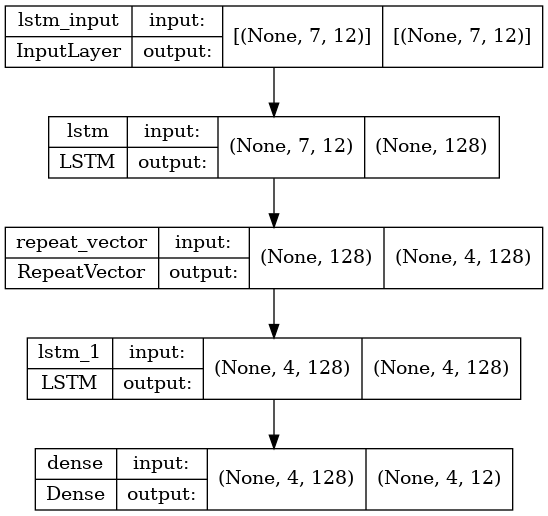

In [11]:
# モデルを画像として出力
from keras.utils.vis_utils import plot_model
plot_model(model,show_shapes=True,to_file='model.png')

In [12]:
# Reverseなしの場合
# 学習の途中でvalidationを表示する
epochs = 30
batch_size = 12

for epoch in range(1,epochs): # 1epoch毎にvalからランダムに抜き出して精度を確認
    history = model.fit(x_train,y_train,batch_size=batch_size,epochs=1,
                       validation_data=(x_val,y_val),)

    for i in range(10):
        ind = np.random.randint(0,len(x_val))
        rowx,rowy = x_val[np.array([ind])],y_val[np.array([ind])]
        preds = np.argmax(model.predict(rowx),axis=-1)
        q = ctable.decode(rowy[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0],calc_argmax=False)
        print("Q", q[::-1] if REVERSE else q, end=" ")
        print("T", correct, end=" ")
        if correct == guess:
            print("〇 " + guess)
        else:
            print("× " + guess)

2022-03-24 20:42:59.455811: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


3750/3750 [==============================] - 28s 7ms/step - loss: 1.6310 - accuracy: 0.3966 - val_loss: 1.3048 - val_accuracy: 0.5059
Q 551  T 551  × 555 
Q 867  T 867  × 862 
Q 138  T 138  × 136 
Q 454  T 454  × 457 
Q 734  T 734  × 712 
Q 157  T 157  × 150 
Q 79   T 79   × 80  
Q 1018 T 1018 × 101 
Q 402  T 402  × 487 
Q 138  T 138  × 110 
3750/3750 [==============================] - 25s 7ms/step - loss: 1.1934 - accuracy: 0.5472 - val_loss: 1.0594 - val_accuracy: 0.5957
Q 401  T 401  × 397 
Q 1137 T 1137 × 1119
Q 1455 T 1455 × 1481
Q 501  T 501  × 493 
Q 1119 T 1119 × 1117
Q 562  T 562  × 587 
Q 429  T 429  × 413 
Q 343  T 343  × 357 
Q 386  T 386  × 377 
Q 1353 T 1353 × 1309
3750/3750 [==============================] - 25s 7ms/step - loss: 0.9719 - accuracy: 0.6291 - val_loss: 0.9018 - val_accuracy: 0.6582
Q 835  T 835  〇 835 
Q 632  T 632  〇 632 
Q 855  T 855  × 847 
Q 159  T 159  × 157 
Q 832  T 832  × 821 
Q 1786 T 1786 × 1715
Q 316  T 316  × 312 
Q 420  T 420  × 412 
Q 819  T 8

In [ ]:
# Reverseありの場合
# 学習の途中でvalidationを表示しない
epochs = 30
batch_size = 12

history = model.fit(x_train,y_train,batch_size=batch_size,epochs=1,
                    validation_data=(x_val,y_val),)

In [ ]:
def plot_loss(history):
    """エポックごとの損失関数をプロットする関数
    
    Args:
    history : fittingの履歴
    
    Returns:
    None
    """
    # 損失関数の履歴を取得
    loss_train = history.history["loss"]
    loss_val = history.history["val_loss"]

    # 損失関数をプロット
    epochs=range(1,len(history.history["loss"])+1)
    plt.figure(facecolor="white")
    plt.plot(epochs,loss_train,label="Training loss")
    plt.plot(epochs,loss_val,label="Validation loss")
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
def plot_acc(history):
    """エポックごとの正解率をプロットする関数
    
    Args:
    history : fittingの履歴
    
    Returns:
    None
    """
    acc_train = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    epochs = range(1,len(history.history["accuracy"])+1)
    plt.figure(facecolor="white")
    plt.plot(epochs, acc_train, 'g', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [ ]:
# 損失関数の描画
plot_loss(history)

In [ ]:
# 正解率を描画
plot_acc(history)

## 推論例

In [14]:
# 好きな数字で推論
a = "123"
b = "456"
q = a+"+"+b # a+b文字列に変換
query = q + " " * (MAXLEN - len(q)) # パディング
if REVERSE: # Reverse処理
        query = query[::-1]
x_new = ctable.encode(query,MAXLEN).astype(np.bool_)
x_new = x_new.reshape(1,-1,12)
pred = np.argmax(model.predict(x_new),axis=-1)
print("predict :",ctable.decode(pred[0],calc_argmax=False))
print("correct :",int(a)+int(b))

predict : 579 
correct : 579
